In [1]:
using CSV, Tables
using DelimitedFiles, DataFrames
using Statistics
import PyPlot as plt
using Plots
using GLM
using ShiftedArrays
using PyCall
using PlotlyJS
using FinancialToolbox
using FinancialDerivatives
using RCall
using LsqFit
using BusinessDays, Dates
using LaTeXStrings
using Random, Distributions
using StatsBase
using PrettyTables
#using MarketTechnicals

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1423


WebIO._IJuliaInit()

In [2]:
"""
yf = pyimport("yfinance")

TWTR = yf.Ticker("TWTR")
TWTR.history(period="6mo").to_csv("DATA/TWTR.csv")

VOD  = yf.Ticker("VOD")
VOD.history(period="6mo").to_csv("DATA/VOD.csv")
"""

"yf = pyimport(\"yfinance\")\n\nTWTR = yf.Ticker(\"TWTR\")\nTWTR.history(period=\"6mo\").to_csv(\"DATA/TWTR.csv\")\n\nVOD  = yf.Ticker(\"VOD\")\nVOD.history(period=\"6mo\").to_csv(\"DATA/VOD.csv\")\n"

### Historical VaR

In [3]:
Stock_1 = DataFrame(CSV.File("DATA/TWTR.csv"))
Stock_2 = DataFrame(CSV.File("DATA/VOD.csv"))

sort!(Stock_1, order(:Date, rev=true))
sort!(Stock_2, order(:Date, rev=true))

Position = 100
Year_Days = 252

#X = [.95, .99, .995]
X = collect(.9:.001:.995)
T = collect(1:100)

function Return( df )
    df[!,:Return    ] =     ( df.Close - lag(df.Close, 1) ) ./ lag(df.Close, 1)
    df[!,:Return_LOG] = log.( df.Close                      ./ lag(df.Close, 1) )
end

function Volatility( Returns, T, daily = false )
    T = floor(Int,T)
    VOL_DAILY  = std(skipmissing(Returns[length(Returns)-T+1:length(Returns)]))
    VOL_ANNUAL = VOL_DAILY * sqrt(Year_Days)
    if daily==false
        return VOL_ANNUAL
    end
    return VOL_DAILY, VOL_ANNUAL
end

Return( Stock_1 )
Return( Stock_2 )

ret_mean_1  = mean(skipmissing(Stock_1.Return))
ret_var_1   = var(skipmissing( Stock_1.Return))
vol_daily_1, vol_annual_1 = Volatility( Stock_1.Return, length(Stock_1.Return), true )

#println("---STOCK 1---")
#println("Mean of the returns:\n",       ret_mean_1  )
#println("\nVariance of the returns:\n", ret_var_1   )
#println("\nDaily volatility:\n",        vol_daily_1 )
#println("\nAnnual volatility:\n",       vol_annual_1)


ret_mean_2  = mean(skipmissing(Stock_2.Return))
ret_var_2   = var(skipmissing( Stock_2.Return))
vol_daily_2, vol_annual_2 = Volatility( Stock_2.Return, length(Stock_2.Return), true )

#println("\n\n---STOCK 2---")
#println("Mean of the returns:\n",       ret_mean_2  )
#println("\nVariance of the returns:\n", ret_var_2   )
#println("\nDaily volatility:\n",        vol_daily_2 )
#println("\nAnnual volatility:\n",       vol_annual_2)


P_Returns = (Stock_1.Return .+ Stock_2.Return) ./ 2
ret_mean  = mean(skipmissing(P_Returns))
ret_var   = var(skipmissing( P_Returns))
vol_daily, vol_annual = Volatility( P_Returns, length(P_Returns), true )

#println("\n\n---Balanced Portfolio---")
#println("Mean of the returns:\n",       ret_mean  )
#println("\nVariance of the returns:\n", ret_var   )
#println("\nDaily volatility:\n",        vol_daily )
#println("\nAnnual volatility:\n",       vol_annual)

data = DataFrame(Parameter=["Mean of the returns", "Variance of the returns", "Daily Volatility", "Annual Volatility"],
                 Stock_1  =[ret_mean_1, ret_var_1, vol_daily_1, vol_annual_1],
                 Stock_2  =[ret_mean_2, ret_var_2, vol_daily_2, vol_annual_2],
                 Portfolio=[ret_mean, ret_var, vol_daily, vol_annual])

pretty_table(data, tf = tf_simple, border_crayon = crayon"bold yellow", header_crayon = crayon"bold green")

========================== ============ ============= ==============
                Parameter      Stock_1       Stock_2     Portfolio  
                   String      Float64       Float64       Float64  
========================== ============ ============= ==============
      Mean of the returns   0.00125994   -0.00029079   0.000484576  
  Variance of the returns   0.00118513    0.00033562   0.000411029  
         Daily Volatility    0.0344258     0.0183199     0.0202739  
        Annual Volatility     0.546492       0.29082      0.321837  
========================== ============ ============= ==============


In [61]:
p = PlotlyJS.plot(candlestick(x    =Stock_1[!, "Date" ],
                              open =Stock_1[!, "Open" ],
                              high =Stock_1[!, "High" ],
                              low  =Stock_1[!, "Low"  ],
                              close=Stock_1[!, "Close"] ),
                  Layout(title="TWTR stock Prices",
                         yaxis_title="TWTR Stock [USD]")
    )
PlotlyJS.savefig(p, "figures/TWTR.pdf")

"figures/TWTR.pdf"

In [62]:
p = PlotlyJS.plot(candlestick(x    =Stock_2[!, "Date" ],
                              open =Stock_2[!, "Open" ],
                              high =Stock_2[!, "High" ],
                              low  =Stock_2[!, "Low"  ],
                              close=Stock_2[!, "Close"] ),
                  Layout(title="VOD stock Prices",
                         yaxis_title="VOD Stock [USD]")
    )
PlotlyJS.savefig(p, "figures/VOD.pdf")

"figures/VOD.pdf"

In [4]:
# maybe we should build the portfolio volatility in this way?
sqrt(.5*vol_annual_1^2+.5*vol_annual_2^2+2*.5*.5*cov(Stock_1.Return[2:length(Stock_1.Return)], Stock_2.Return[2:length(Stock_2.Return)])*252)


0.4465275420574706

In [64]:
daily_change_1 = Position/2 * vol_daily_1
std_change_1   = daily_change_1 .* sqrt.(T)

daily_change_2 = Position/2 * vol_daily_2
std_change_2   = daily_change_2 .* sqrt.(T)

daily_change = Position * vol_daily
std_change   = daily_change .* sqrt.(T)

VaR_1 = transpose(-quantile.(Normal(), 1 .- X)) .* std_change_1
VaR_2 = transpose(-quantile.(Normal(), 1 .- X)) .* std_change_2

VaR = transpose(-quantile.(Normal(), 1 .- X)) .* std_change

my_cg = cgrad([:blue, :orange])

In [65]:
"""VaR_1 = transpose(-quantile(skipmissing(Stock_1.Return), 1 .- X)) .* std_change_1
VaR_2 = transpose(-quantile(skipmissing(Stock_2.Return), 1 .- X)) .* std_change_2

VaR = transpose(-quantile(skipmissing(P_Returns), 1 .- X)) .* Position

-quantile.(Normal(), 1 .- X)"""

"VaR_1 = transpose(-quantile(skipmissing(Stock_1.Return), 1 .- X)) .* std_change_1\nVaR_2 = transpose(-quantile(skipmissing(Stock_2.Return), 1 .- X)) .* std_change_2\n\nVaR = transpose(-quantile(skipmissing(P_Returns), 1 .- X)) .* Position\n\n-quantile.(Normal(), 1 .- X)"

In [66]:
VaR_Plot  =Plots.plot(title = "Joint Portfolio",X, T, VaR,              st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
VaR_Plot_1=Plots.plot(title = "Twitter",        X, T, VaR_1,            st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
VaR_Plot_2=Plots.plot(title = "Vodafone",       X, T, VaR_2,            st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
Dif_Plot  =Plots.plot(title = "Non-Additivity", X, T, (VaR_1+VaR_2-VaR),st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")


Plots.plot(VaR_Plot_1, VaR_Plot_2, VaR_Plot, Dif_Plot, layout = (2, 2), size = (1920, 1080))
Plots.plot!(#gridcolor=:green,
            gridlinestyle=:dot,
            gridlinewidth=1,
            gridalpha=0.8)
Plots.savefig("figures/VaR_Normal.pdf")

In [8]:
layout = PlotlyJS.Layout(
    title="VaR",
    scene_yaxis_title="Confidence",
    scene_xaxis_title="Days",
    scene_zaxis_title="VaR",
    autosize=false,
    scene_camera_eye=attr(x=-1.87, y=0.88, z=0.64),
    width=1000, height=1000,
    margin=attr(l=65, r=50, b=65, t=90)
)

PlotlyJS.plot(PlotlyJS.surface(
        x=T,
        y=X,
        z=VaR,
        contours_z=attr(
            show=true,
            usecolormap=true,
            highlightcolor="limegreen",
            project_z=true
        )
), layout)

data: [
  "surface with fields contours, type, x, y, and z"
]

layout: "layout with fields autosize, height, margin, scene, template, title, and width"

## EWMA

In [68]:
P_Returns_squared_1 = Stock_1.Return .^ 2
P_Returns_squared_2 = Stock_2.Return .^ 2

P_Returns_squared = P_Returns .^ 2

lambda = .94

#weights_EWMA = [1-lambda]
#for i=2:length(P_Returns)
#    append!(weights_EWMA, weights_EWMA[i-1]*lambda)
#end

weights_EWMA = vcat(missing, [(1-lambda)*lambda^i for i in 0:length(P_Returns)-2])

weighted_returns_1 = P_Returns_squared_1 .* weights_EWMA
vol_daily_EWMA_1   = sqrt(sum(skipmissing(weighted_returns_1)))
weighted_returns_2 = P_Returns_squared_2 .* weights_EWMA
vol_daily_EWMA_2   = sqrt(sum(skipmissing(weighted_returns_1)))

weighted_returns = P_Returns_squared .* weights_EWMA
vol_daily_EWMA   = sqrt(sum(skipmissing(weighted_returns)))

Plots.plot(title="Weights and weighted returns",margin=13Plots.mm, size = (720, 480))
Plots.plot!(weights_EWMA,label="weights",legend=:top, color="blue")
Plots.plot!(twinx(),weighted_returns,label="weighted returns",legend=:topright, color="red")

Plots.savefig("figures/Weights_EWMA.pdf")

In [70]:
daily_change_EWMA_1 = Position/2 * vol_daily_EWMA_1
std_change_EWMA_1   = daily_change_EWMA_1 .* sqrt.(T)
VaR_EWMA_1 = transpose(-quantile.(Normal(), 1 .- X)) .* std_change_EWMA_1

daily_change_EWMA_2 = Position/2 * vol_daily_EWMA_2
std_change_EWMA_2   = daily_change_EWMA_2 .* sqrt.(T)
VaR_EWMA_2 = transpose(-quantile.(Normal(), 1 .- X)) .* std_change_EWMA_2


daily_change_EWMA = Position * vol_daily_EWMA
std_change_EWMA   = daily_change_EWMA .* sqrt.(T)

VaR_EWMA = transpose(-quantile.(Normal(), 1 .- X)) .* std_change_EWMA

100×3 Matrix{Float64}:
  4.12378   5.83235   6.45782
  5.83191   8.24818   9.13273
  7.1426   10.1019   11.1853
  8.24757  11.6647   12.9156
  9.22106  13.0415   14.4401
 10.1012   14.2863   15.8184
 10.9105   15.4309   17.0858
 11.6638   16.4964   18.2655
 12.3714   17.497    19.3735
 13.0406   18.4435   20.4214
 13.677    19.3437   21.4182
 14.2852   20.2038   22.3705
 14.8685   21.0288   23.284
  ⋮                  
 38.9037   55.0222   60.9229
 39.1217   55.3305   61.2642
 39.3384   55.637    61.6037
 39.5539   55.9419   61.9412
 39.7683   56.2451   62.2769
 39.9816   56.5467   62.6109
 40.1937   56.8467   62.943
 40.4047   57.1451   63.2734
 40.6146   57.442    63.6021
 40.8234   57.7373   63.9291
 41.0311   58.0311   64.2545
 41.2378   58.3235   64.5782

In [71]:
VaR_Plot_EWMA  =Plots.plot(title = "Joint Portfolio",X, T, VaR_EWMA,              st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
VaR_Plot_EWMA_1=Plots.plot(title = "Twitter",        X, T, VaR_EWMA_1,            st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
VaR_Plot_EWMA_2=Plots.plot(title = "Vodafone",       X, T, VaR_EWMA_2,            st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
Dif_Plot_EWMA  =Plots.plot(title = "Non-Additivity", X, T, (VaR_EWMA_1+VaR_EWMA_2-VaR_EWMA),st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")


Plots.plot(VaR_Plot_EWMA_1, VaR_Plot_EWMA_2, VaR_Plot_EWMA, Dif_Plot_EWMA, layout = (2, 2), size = (1920, 1080))
Plots.plot!(#gridcolor=:green,
            gridlinestyle=:dot,
            gridlinewidth=1,
            gridalpha=0.8)
Plots.savefig("figures/VaR_EWMA.pdf")

#VaR_Plot_EWMA_1=Plots.plot(title = L"VaR",X, T, VaR_EWMA_1,st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence", ylabel="Spot price [USD]", zlabel="Call Option Price [USD]")
#VaR_Plot_EWMA_2=Plots.plot(title = L"VaR",X, T, VaR_EWMA_2,st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence", ylabel="Spot price [USD]", zlabel="Call Option Price [USD]")

#Plots.plot(VaR_Plot_EWMA_1, VaR_Plot_EWMA_2, layout = (1, 2), size = (1440, 720))
#Plots.plot!(#gridcolor=:green,
#            gridlinestyle=:dot,
#            gridlinewidth=1,
#            gridalpha=0.8)

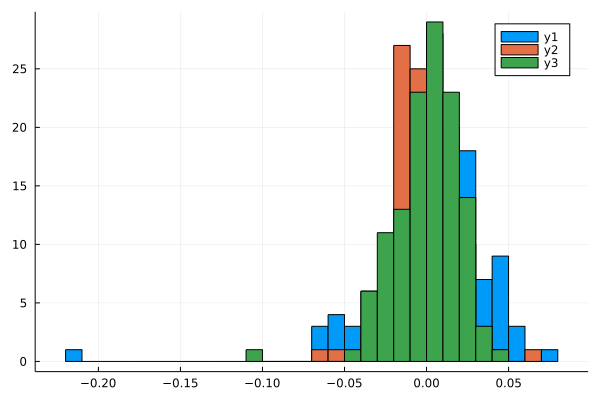

In [8]:
Plots.histogram( Stock_1.Return[2:length(P_Returns)], bins=30)
Plots.histogram!(Stock_2.Return[2:length(P_Returns)], bins=20)
Plots.histogram!(     P_Returns[2:length(P_Returns)], bins=20)

## Monte Carlo Simulation

In [74]:
X = [.95, .99, .995]

e=randn(10000)
T=[1/252,  1/12,   3/12,     6/12,        1]
r=[.00325, .008, .01286, .0184814, .0254914]

sv_1=[exp((r[i]-.5*vol_annual_1^2)*T[i] + vol_annual_1*sqrt(T[i])*e[j]) for j=1:length(e), i=1:length(T)]
sv_2=[exp((r[i]-.5*vol_annual_2^2)*T[i] + vol_annual_2*sqrt(T[i])*e[j]) for j=1:length(e), i=1:length(T)]

sv=[exp((r[i]-.5*vol_annual^2)*T[i] + vol_annual*sqrt(T[i])*e[j]) for j=1:length(e), i=1:length(T)]

percent_loss_1 =Array{Float64}( undef, length(X), length(T) )
absolute_loss_1=Array{Float64}( undef, length(X), length(T) )
percent_loss_2 =Array{Float64}( undef, length(X), length(T) )
absolute_loss_2=Array{Float64}( undef, length(X), length(T) )

percent_loss =Array{Float64}( undef, length(X), length(T) )
absolute_loss=Array{Float64}( undef, length(X), length(T) )
for j=1:length(X), i=1:length(T)
    percent_loss_1[j,i] =1-percentile(sv_1[:, i], 1-X[j])
    absolute_loss_1[j,i]=percent_loss_1[j,i]*Position/2
    
    percent_loss_2[j,i] =1-percentile(sv_2[:, i], 1-X[j])
    absolute_loss_2[j,i]=percent_loss_2[j,i]*Position/2
    
    percent_loss[j,i] =1-percentile(sv[:, i], 1-X[j])
    absolute_loss[j,i]=percent_loss[j,i]*Position
end

absolute_loss

3×5 Matrix{Float64}:
 6.2455   25.7921  40.5528  52.2121  64.901
 6.86531  28.0137  43.6015  55.6408  68.4087
 7.1071   28.8622  44.743   56.8998  69.6616

In [76]:
p=PlotlyJS.plot([PlotlyJS.histogram(x=sv[:,i], opacity=0.5, name=string(T[i]*252)) for i=5:-1:1], 
                Layout(title="Ending Values",
                       yaxis_title="Frequency", xaxis_title="Ending Value", 
                       barmode="overlay"))
PlotlyJS.savefig(p,"figures/MonteCarlo.pdf")

"figures/MonteCarlo.pdf"

In [78]:
absolute_loss_1 .+ absolute_loss_2 .- absolute_loss
VaR_Plot_MC  =Plots.plot(title = "Joint Portfolio",X, T, transpose(absolute_loss),                                st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
VaR_Plot_MC_1=Plots.plot(title = "Twitter",        X, T, transpose(absolute_loss_1),                              st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
VaR_Plot_MC_2=Plots.plot(title = "Vodafone",       X, T, transpose(absolute_loss_2),                              st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
Dif_Plot_MC  =Plots.plot(title = "Non-Additivity", X, T, transpose(absolute_loss_1+absolute_loss_2-absolute_loss),st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")


Plots.plot(VaR_Plot_1, VaR_Plot_2, VaR_Plot, Dif_Plot, layout = (2, 2), size = (1920, 1080))
Plots.plot!(#gridcolor=:green,
            gridlinestyle=:dot,
            gridlinewidth=1,
            gridalpha=0.8)
Plots.savefig("figures/VaR_MC.pdf")

#Plots.plot(title = "Non-Additivity",T, X, absolute_loss_1 .+ absolute_loss_2 .- absolute_loss,st=:surface,color=my_cg, camera=(45,30), xlabel="Time [Days]", ylabel="Confidence Level", zlabel="VaR [USD]")

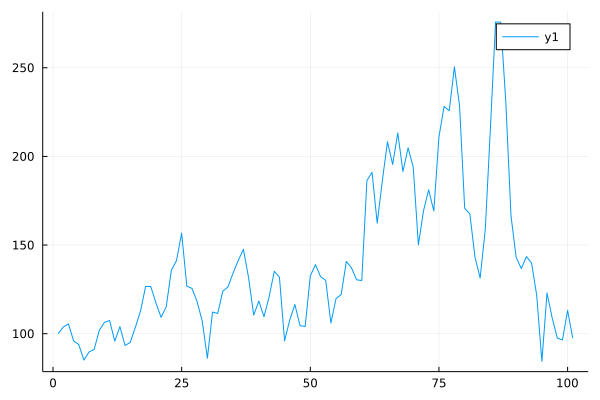

In [108]:
X = [.95, .99, .995]

e=randn((40,100))
T=1:100
r=0

sv=[exp((r-.5*vol_annual^2)*T[i]/Year_Days + vol_annual*sqrt(T[i]/Year_Days)*e[j, i]) for i=1:length(T), j=1:40]
PNL = [100.,]
for i=1:100
    append!(PNL, PNL[i]*sv[i,10])
end

Plots.plot(PNL)

## Historical VaR

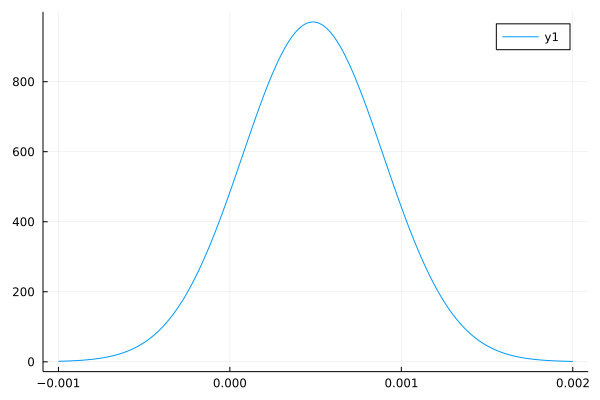

In [143]:
norm = Normal(ret_mean, ret_var)
x = -.001:.00001:.002
norm_port = pdf.(norm, x)
Plots.plot(x, norm_port)

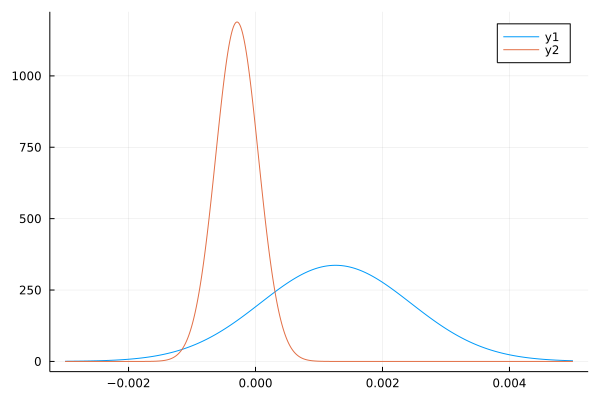

In [145]:
x = -.003:.00001:.005

norm   = Normal(ret_mean_1, ret_var_1)
norm_1 = pdf.(norm, x)

norm   = Normal(ret_mean_2, ret_var_2)
norm_2 = pdf.(norm, x)

Plots.plot( x,norm_1)
Plots.plot!(x,norm_2)


VaR_1 = transpose(-quantile.(Normal(ret_mean_1, ret_var_1), 1 .- X)) .* std_change_1
VaR_2 = transpose(-quantile.(Normal(ret_mean_2, ret_var_2), 1 .- X)) .* std_change_2

VaR = transpose(-quantile.(Normal(ret_mean, ret_var), 1 .- X)) .* std_change

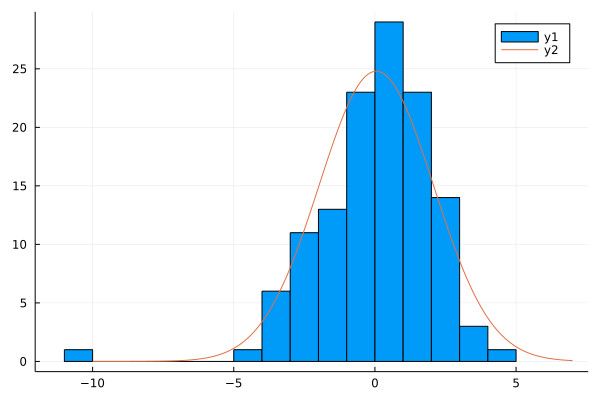

In [80]:
gain = P_Returns[2:length(P_Returns)] * Position
mea =mean(gain)
stdd=std(gain)
Plots.histogram(gain, bins=20)
x=-10:.01:7
Plots.plot!(x, length(P_Returns)*pdf.(Normal(mea, stdd), x))

In [82]:
gain_1=Stock_1.Return[2:length(Stock_1.Return)] * Position/2
mea_1 =mean(gain_1)
stdd_1=std(gain_1)

gain_2=Stock_2.Return[2:length(Stock_2.Return)] * Position/2
mea_2 =mean(gain_2)
stdd_2=std(gain_2)

#X = [.95, .99, .995]
X = collect(.9:.001:.995)
T = collect(1:100)

VaR_Hist  =transpose(-quantile.([gain], 1 .- X)) .* sqrt.(T)
VaR_Hist_1=transpose(-quantile.([gain_1], 1 .- X)) .* sqrt.(T)
VaR_Hist_2=transpose(-quantile.([gain_2], 1 .- X)) .* sqrt.(T)
Dif_Hist  =VaR_Hist_1+VaR_Hist_2-VaR_Hist

100×96 Matrix{Float64}:
 0.262132  0.245247  0.228362  0.211478  …   1.72017   1.97341   2.22666
 0.37071   0.346832  0.322953  0.299075      2.43269   2.79083   3.14897
 0.454025  0.42478   0.395535  0.36629       2.97943   3.41805   3.85668
 0.524263  0.490494  0.456725  0.422956      3.44034   3.94683   4.45331
 0.586144  0.548389  0.510634  0.472879      3.84642   4.41269   4.97896
 0.642089  0.60073   0.559371  0.518013  …   4.21354   4.83386   5.45417
 0.693535  0.648863  0.60419   0.559518      4.55115   5.22116   5.89118
 0.74142   0.693663  0.645907  0.59815       4.86538   5.58166   6.29794
 0.786395  0.735741  0.685087  0.634434      5.16052   5.92024   6.67997
 0.828933  0.775539  0.722145  0.668752      5.43966   6.24048   7.04131
 0.869392  0.813392  0.757393  0.701393  …   5.70517   6.54508   7.38499
 0.908051  0.849561  0.791071  0.732581      5.95885   6.83611   7.71337
 0.945129  0.884251  0.823373  0.762494      6.20217   7.11525   8.02833
 ⋮                         

In [83]:
VaR_Plot_Hist  =Plots.plot(title = "Joint Portfolio",X, T, VaR_Hist,   st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
VaR_Plot_Hist_1=Plots.plot(title = "Twitter",        X, T, VaR_Hist_1, st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
VaR_Plot_Hist_2=Plots.plot(title = "Vodafone",       X, T, VaR_Hist_2, st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")
Dif_Plot_Hist  =Plots.plot(title = "Non-Additivity", X, T, Dif_Hist,   st=:surface,color=my_cg, camera=(45,30), xlabel="Confidence Level", ylabel="Time [Days]", zlabel="VaR [USD]")


Plots.plot(VaR_Plot_Hist_1, VaR_Plot_Hist_2, VaR_Plot_Hist, Dif_Plot_Hist, layout = (2, 2), size = (1920, 1080))
Plots.plot!(#gridcolor=:green,
            gridlinestyle=:dot,
            gridlinewidth=1,
            gridalpha=0.8)
Plots.savefig("figures/VaR_Hist.pdf")